In [ ]:
import pandas as pd
import numpy as np
import keras
import keras.layers as L
import keras.models as M
import tensorflow as tf
from PIL import Image
import os
import matplotlib.pyplot as plt
import cv2
from keras.utils import Sequence
import seaborn as sns

In [ ]:
train=pd.read_csv('written_name_test_v2.csv')
validation=pd.read_csv('written_name_test_v2.csv')


In [ ]:
train.dropna(inplace=True)
train.head()

,FILENAME,IDENTITY
0,TEST_0001.jpg,KEVIN
1,TEST_0002.jpg,CLOTAIRE
2,TEST_0003.jpg,LENA
3,TEST_0004.jpg,JULES
4,TEST_0005.jpg,CHERPIN


In [ ]:
train[train['IDENTITY']=='zucchi']
train['Length']=train['IDENTITY'].apply(lambda x : len(str(x)))
train=train[train['Length']<=21]
train['IDENTITY']=train['IDENTITY'].str.upper()
train[train['Length']==max(train['Length'])]




,FILENAME,IDENTITY,Length
40625,TEST_40626.jpg,DE GARNIER DES GARETS,21


In [ ]:
train=train.sample(frac=0.8,random_state=42)
validation=validation.sample(frac=0.1)
characters=set()
train['IDENTITY']=train['IDENTITY'].apply(lambda x: str(x))
for i in train['IDENTITY'].values:
    for j in i :
        if j not in characters :
            characters.add(j)
characters=sorted(characters)
# 2 Dictionaries  :   Turn all ur characters to num and vice versa
char_to_label = {char:label for label,char in enumerate(characters)}
label_to_char = {label:char for label,char in enumerate(characters)}
path_train='written_name_test_v2.csv'
path_validation='written_name_test_v2.csv'
class DataGenerator(Sequence):
    def __init__(self,dataframe,path,char_map,batch_size=128,img_size=(256,64),
                 downsample_factor=4,max_length=22,shuffle=True):
        self.dataframe=dataframe
        self.path=path
        self.char_map=char_map
        self.batch_size=batch_size
        self.width=img_size[0]
        self.height=img_size[1]
        self.downsample_factor=downsample_factor
        self.max_length=max_length
        self.shuffle=shuffle
        self.indices = np.arange(len(dataframe))
        self.on_epoch_end()

    def __len__(self):
        return len(self.dataframe)//self.batch_size

    def __getitem__(self,idx):
        curr_batch_idx=self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_images=np.ones((self.batch_size,self.width,self.height,1),dtype=np.float32)
        batch_labels=np.ones((self.batch_size,self.max_length),dtype=np.float32)
        input_length=np.ones((self.batch_size,1),dtype=np.float32)*(self.width//self.downsample_factor-2)
        label_length=np.zeros((self.batch_size,1),dtype=np.int64)
        for i,idx in enumerate(curr_batch_idx):
            img_path=self.dataframe['FILENAME'].values[idx]
            img=cv2.imread(self.path+'/'+img_path)
            img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img=cv2.resize(img,(self.width,self.height))
            img=(img/255).astype(np.float32)
            img=img.T
            img=np.expand_dims(img,axis=-1)
            text=self.dataframe['IDENTITY'].values[idx]
            text=str(text)
            label=[]
            for j in text:
                if j in self.char_map :
                    label.append(self.char_map[j])
                else:
                    label.append(100)
            label.extend([100]*(22-len(label)))
            batch_images[i]=img
            batch_labels[i]=label
            label_length[i]=len(label)
        batch_inputs= {
                'input_data':batch_images,
                'input_label':batch_labels,
                'input_length':input_length,
                'label_length':label_length

            }
        return batch_inputs,np.zeros((self.batch_size),dtype=np.float32)
    def on_epoch_end(self):
        if self.shuffle == True :
            np.random.shuffle(self.indices)

train_generator=DataGenerator(train,path_train,char_to_label)
validation_generator=DataGenerator(validation,path_validation,char_to_label)
# Making CTC Function
class CTCLayer(L.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred, input_length, label_length):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # On test time, just return the computed loss
        return loss
# Making the Model now
def make_model():
    inp=L.Input(shape=(256,64,1),dtype=np.float32,name='input_data')
    labels=L.Input(shape=[22],dtype=np.float32,name='input_label')
    input_length=L.Input(shape=[1],dtype=np.int64,name='input_length')
    label_length=L.Input(shape=[1],dtype=np.int64,name='label_length')
    x=L.Conv2D(64,(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(inp)
    x=L.MaxPooling2D(pool_size=(2,2))(x)
    x=L.Dropout(0.3)(x)
    x=L.Conv2D(128,(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(x)
    x=L.MaxPooling2D(pool_size=(2,2))(x)
    x=L.Dropout(0.3)(x)
    new_shape=((256//4),(64//4)*128)
    x=L.Reshape(new_shape)(x)
    x=L.Dense(64,activation='relu')(x)
    x=L.Dropout(0.2)(x)
    x=L.Bidirectional(L.LSTM(128,return_sequences=True,dropout=0.2))(x)
    x=L.Bidirectional(L.LSTM(64,return_sequences=True,dropout=0.25))(x)
    x=L.Dense(len(characters)+1,activation='softmax',kernel_initializer='he_normal',name='Dense_output')(x)
    output=CTCLayer(name='outputs')(labels,x,input_length,label_length)
    model=M.Model([inp,labels,input_length,label_length],output)

    return model
model=make_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_data (InputLayer)     [(None, 256, 64, 1)]         0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 256, 64, 64)          640       ['input_data[0][0]']          
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 128, 32, 64)          0         ['conv2d_4[0][0]']            
 g2D)                                                                                             
                                                                                                  
 dropout_6 (Dropout)         (None, 128, 32, 64)          0         ['max_pooling2d_4[0][0]'

In [ ]:
# Add early stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                   patience=5,
                                   restore_best_weights=True)


prediction_model = keras.models.Model(model.get_layer(name='input_data').input,
                                        model.get_layer(name='Dense_output').output)
prediction_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_data (InputLayer)     [(None, 256, 64, 1)]      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 256, 64, 64)       640       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 128, 32, 64)       0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 128, 32, 64)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 32, 128)      73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 64, 16, 128)       0         
 g2D)                                                      

In [ ]:
if 'prediction_model_ocr.h5' not in os.listdir('./'):
    prediction_model.save('prediction_model_ocr.h5')
    prediction_model=M.load_model('prediction_model_ocr.h5')
label_to_char[100]=''
def decode_batch_predictions(pred):
    pred = pred[:, :-2]
    input_len = np.ones(pred.shape[0])*pred.shape[1]

    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred,
                                        input_length=input_len,
                                        greedy=True)[0][0]

    # Iterate over the results and get back the text
    output_text = []
    for res in results.numpy():
        outstr = ''
        for c in res:
            if c < len(characters) and c >=0:
                outstr += label_to_char[c]
        output_text.append(outstr)

    # return final text results
    return output_text


In [ ]:
for p, (inp_value, _) in enumerate(validation_generator):
    bs = inp_value['input_data'].shape[0]
    X_data = inp_value['input_data']
    labels = inp_value['input_label']
    plt.imshow(X_data[0])
    preds = prediction_model.predict(X_data)
    pred_texts = decode_batch_predictions(preds)


    orig_texts = []
    for label in labels:
        text = ''.join([label_to_char[int(x)] for x in label])
        orig_texts.append(text)

    for i in range(bs):
        print(f'Ground truth: {orig_texts[i]} \t Predicted: {pred_texts[i]}')
    break
    train.hist(figsize=(14,12))
    plt.show()

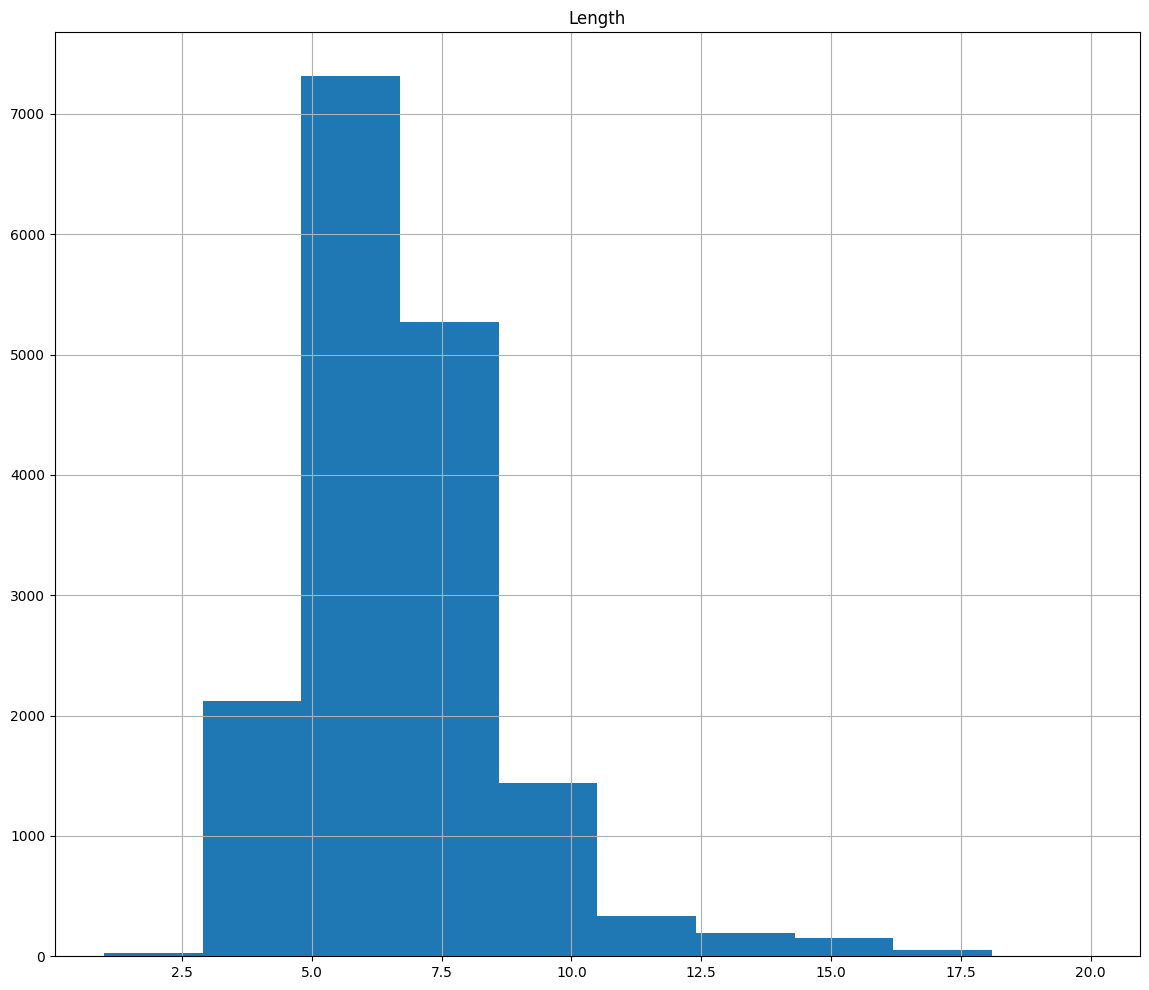

In [ ]:
 train.hist(figsize=(14,12))
 plt.show()